# Notebook settings

### Don't change these parameters :0

In [1]:
''' These parameters should not be changed!!!'''

# check device
import torch
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# pytorch weight initialization seed
RANDOM_SEED = 42

# model-specific image sizes
LENET5_IMG_SIZE = 32

### These parameters can be tampered with

In [2]:
'''These parameters can potentially be changed...'''

LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15
N_CLASSES = 10

### Helper Functions

In [3]:
def get_dataloaders(X, y, validation_split_index):
    '''Gets the training and validation dataloaders for a given dataset by using an index to split into training and validation.'''
    # get partitioned training and validation numpy arrays from the dataset
    x_train, x_val = data.split_train_and_val(X, validation_split_index)
    y_train, y_val = data.split_train_and_val(y, validation_split_index)

    # Make tensors out of the numpy arrays
    x_train, y_train, x_val, y_val = map(torch.tensor, (x_train, y_train, x_val, y_val))

    # Make TensorDatasets
    from torch.utils.data import TensorDataset
    train_ds = TensorDataset(x_train, y_train)
    val_ds = TensorDataset(x_val, y_val)

    # Make DataLoaders
    from torch.utils.data import DataLoader
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)
    val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)

    # return training and validation dataloaders :)
    return train_dl, val_dl

def downsample(batch, size=32):
    '''Downsamples the data to fit model requirements. I couldn't find a way around this that worked effectively...'''
    batch = batch.view(-1, 1, 56, 56) # Resize input to make it square
    downsample = nn.AdaptiveAvgPool2d(size) # Define a downsampling function
    batch = downsample(batch) # Downsample the batch's image data
    return batch


# Semi-supervised learning
We try and initialize the model weights by first training it on a different task: predicting image rotations on the unlabeled dataset that was given to us.

### Load Unlabeled Data
The 30,000 unlabeled samples have each been rotated 3 times (by 90, 180, and 270 degreeses respectively,) and merged into an array of 120,000 images and an array of 120,000 rotation labels (0, 1, 2, 3 corresponding to each rotation.)

In [4]:
import assignment_data as data

SPLIT_INDEX = 100000 # 100,000 training and 20,000 validation
train_dl, val_dl = get_dataloaders(data.rotated_images, data.rotated_image_labels, SPLIT_INDEX)

### Train LeNet5 on the Image Rotation Task

23:11:16 --- Epoch: 0	Train loss: 1.0465	Valid loss: 0.9910	Train accuracy: 50.33	Valid accuracy: 49.45


c:\Users\dodob\OneDrive\Desktop\ML\a3comp551\sams_plotting.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


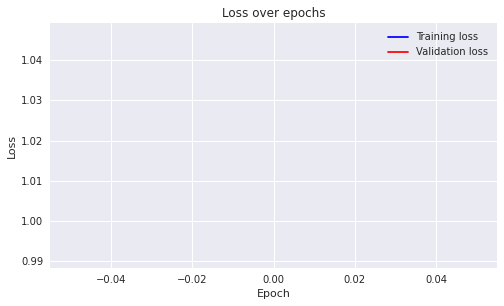

In [5]:
from model_definitions import LeNet5
from torch import nn
from model_training import training_loop
import assignment_data as data

LEARNING_RATE = 0.001
BATCH_SIZE = 64
N_EPOCHS = 7
N_CLASSES = 4
lenet5 = LeNet5(N_CLASSES, preprocess=downsample) # Load LeNet architecture
optimizer = torch.optim.Adam(lenet5.parameters(), lr=LEARNING_RATE) # Load optimizer
criterion = nn.CrossEntropyLoss() # Specifiy loss function
model, optimizer, _ = training_loop(lenet5, criterion, optimizer, train_dl, val_dl, N_EPOCHS, DEVICE)

### Load Labeled Data
This data is used to train the network on our specific task of classifying images by number-letter combination.

In [14]:
SPLIT_INDEX = 25000 # 25,000 training and 5,000 validation
train_dl, val_dl = get_dataloaders(data.labeled_images, data.integer_labels(), SPLIT_INDEX)

### Train LeNet5 on the Assigned Task

23:15:08 --- Epoch: 0	Train loss: 5.5210	Valid loss: 5.4869	Train accuracy: 1.13	Valid accuracy: 0.76


c:\Users\dodob\OneDrive\Desktop\ML\a3comp551\sams_plotting.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


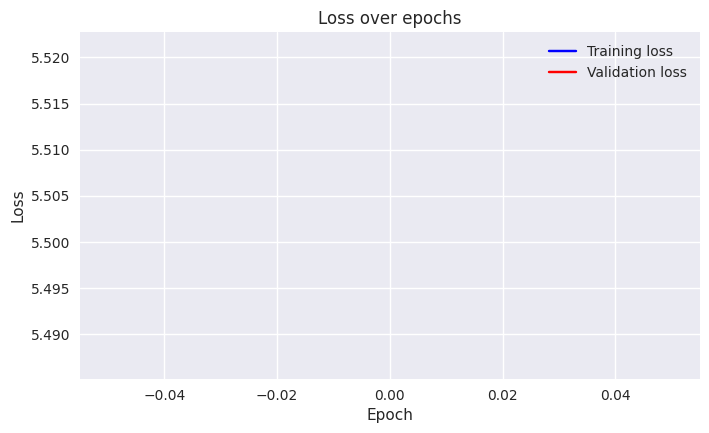

In [15]:
LEARNING_RATE = 0.001
BATCH_SIZE = 64
N_EPOCHS = 50
N_CLASSES = 260

# Chop the head off from the classifier (change number of output classes but keep the feature extractor)
from torch import nn
lenet5.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=260),
        )
model, optimizer, _ = training_loop(lenet5, criterion, optimizer, train_dl, val_dl, N_EPOCHS, DEVICE)